# Deep Q-Learning

In [1]:
#@title Importando as Bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random
import plotly.graph_objects as go

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace
from collections import deque
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
#@title Carregando os Dados
dataset = read_csv('/content/SP500.csv',index_col=0)

import warnings
warnings.filterwarnings('ignore')

type(dataset)

pandas.core.frame.DataFrame

# Análise Exploratória dos Dados (EDA)

In [ ]:
#@title Shape do Dataset
dataset.shape

(2516, 6)

In [ ]:
#@title Entendendo os Dados
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [ ]:
#@title Descrição dos Dados
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,1962.147905,1971.346574,1952.200450,1962.608854,1962.608854,3.715246e+09
std,589.031496,590.190988,587.623893,588.910251,588.910251,8.134033e+08
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,1.025000e+09
25%,1381.642548,1390.700012,1372.800018,1384.404999,1384.404999,3.237625e+09
50%,1985.319946,1993.084961,1975.660034,1986.479981,1986.479981,3.587920e+09
75%,2434.179931,2441.522522,2427.959961,2433.967529,2433.967529,4.076530e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.061781e+10


In [ ]:
#@title Gráfico Candlestick
fig = go.Figure(data = [go.Candlestick(x = dataset.index,
                                       open=dataset['Open'],
                                       high=dataset['High'],
                                       low=dataset['Low'],
                                       close=dataset['Close']
                                       )])
fig.show()

# Preparação dos Dados

In [ ]:
#@title Verificando se existem valores nulos
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [ ]:
#@title Caso exista preencher com método ffill
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.98999,1132.98999,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.52002,1136.52002,2491020000


# Avaliando Modelos e Algoritmos

### Train Test Split

In [ ]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [ ]:
#@title Divisão dos Dados

# Define a proporção do conjunto de validação
validation_split = 0.2

# Divide os dados sequencialmente, preservando a ordem temporal
split_index = int(len(X) * (1 - validation_split))
X_train = X[:split_index]
X_test = X[split_index:]

In [ ]:
#@title Classe Agente Modelo
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size
        self.action_size = 3  # [0: manter, 1: comprar, 2: vender]
        self.memory = deque(maxlen=500)  # menor buffer de memória
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95             # fator de desconto reduzido
        self.epsilon = 1.0            # taxa de exploração inicial
        self.epsilon_min = 0.01       # maior valor mínimo para não ficar muito exploratório
        self.epsilon_decay = 0.99     # decaimento mais rápido

        self.model = load_model(model_name) if is_eval and model_name else self._model()

    def _model(self):
        model = Sequential()
        # Rede neural mais leve
        model.add(Dense(64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(32, activation="relu"))
        model.add(Dense(8, activation="relu"))  # camada intermediária ajuda a generalização
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001)) #Taxa de aprendizado
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def expReplay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        mini_batch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                next_q_values = self.model.predict(next_state, verbose=0)
                target += self.gamma * np.amax(next_q_values[0])

            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target

            self.model.fit(state, target_f, epochs=1, verbose=0, batch_size=8)  # pequeno batch_size interno

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Funções Auxiliares

In [ ]:
# Formata o preço com sinal de negativo ou positivo e 2 casas decimais
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# Função sigmoide para normalização
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Retorna o vetor de estado com base na diferença de preços normalizada (n dias)
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else [-data[0]] * -d + data[0:t + 1]  # preenche com valor inicial se necessário
    res = [sigmoid(block[i + 1] - block[i]) for i in range(n - 1)]
    return np.array([res])

# Plota sinais de compra e venda junto à série de preços
def plot_behavior(data_input, states_buy, states_sell, profit):
    plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='blue', lw=2., label='Preço')
    plt.plot(data_input, '^', markersize=10, color='green', label='Compra', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='red', label='Venda', markevery=states_sell)
    plt.title(f'Lucro total: {profit:.2f}')
    plt.legend()
    plt.show()

# Treinamento dos Dados

Treinando episódios:   0%|          | 0/6 [00:00<?, ?it/s]


--------------------------------
Episódio: 0
Lucro Total: $1087.19
--------------------------------


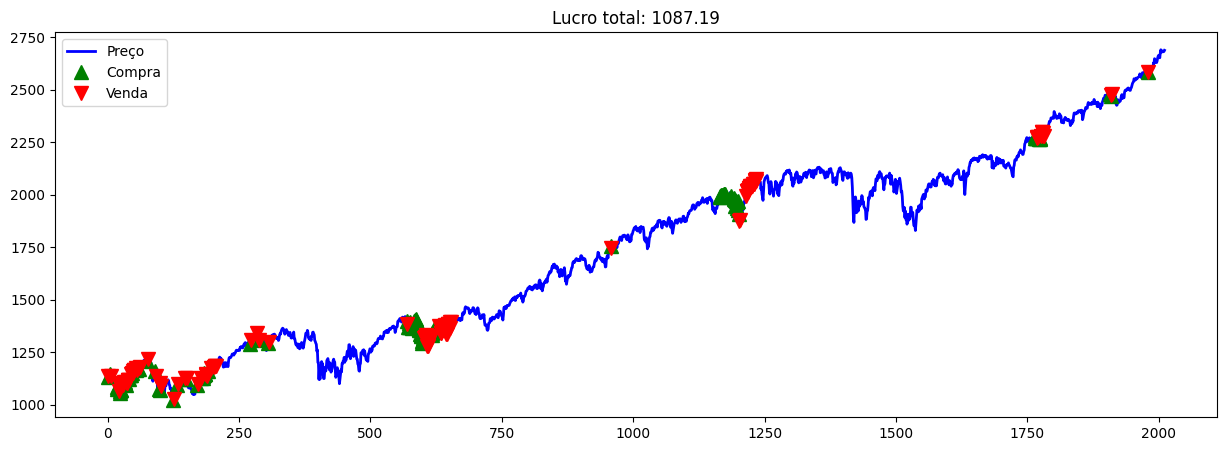

Treinando episódios:  17%|█▋        | 1/6 [3:40:45<18:23:48, 13245.71s/it]


--------------------------------
Episódio: 1
Lucro Total: $8574.96
--------------------------------


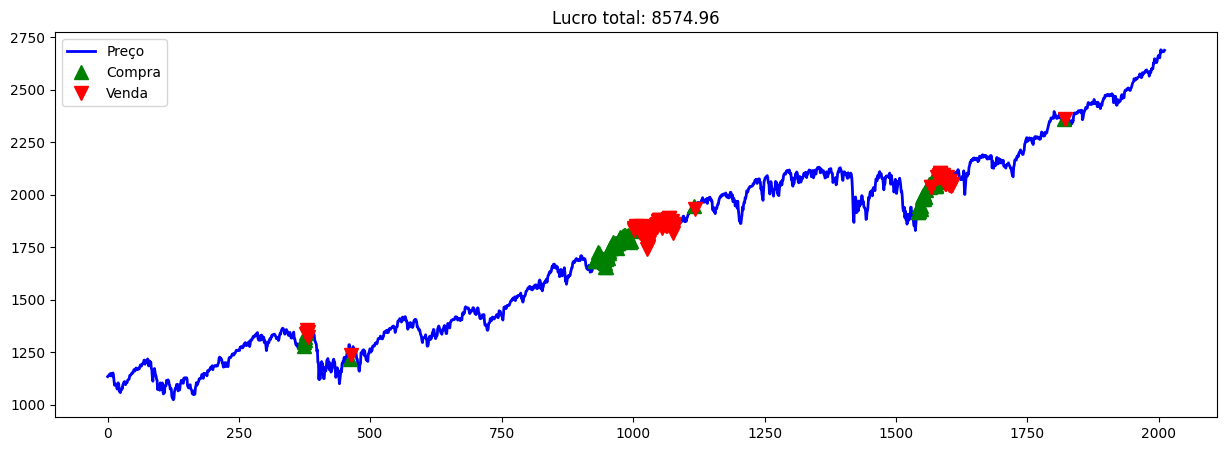

Treinando episódios:  33%|███▎      | 2/6 [7:24:12<14:49:21, 13340.49s/it]


--------------------------------
Episódio: 2
Lucro Total: $13828.55
--------------------------------


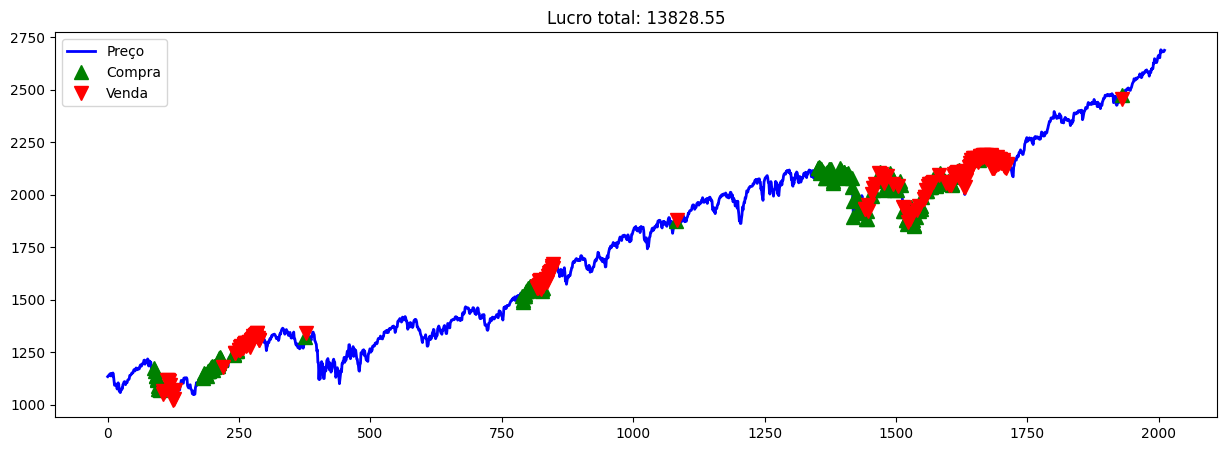

Treinando episódios:  50%|█████     | 3/6 [10:59:49<10:57:48, 13156.17s/it]

In [ ]:
from IPython.core.debugger import set_trace
from tqdm import tqdm  # Adiciona barra de progresso

# Parâmetros
window_size = 1
batch_size = 16
episode_count = 5

# Inicializar agente
agent = Agent(window_size)

# Dados de entrada (supondo que X_train já esteja definido)
data = X_train
data_length = len(data)

if data_length < window_size + 2:
    raise ValueError("Dados insuficientes para a janela especificada.")

# Loop de treinamento com barra de progresso
for episode in tqdm(range(episode_count + 1), desc="Treinando episódios"):
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    states_buy = []
    states_sell = []

    for t in range(data_length - 1):
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # comprar
            agent.inventory.append(data[t])
            states_buy.append(t)

        elif action == 2 and len(agent.inventory) > 0:  # vender
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)

        done = (t == data_length - 2)
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("\n--------------------------------")
            print("Episódio:", episode)
            print("Lucro Total:", formatPrice(total_profit))
            print("--------------------------------")
            plot_behavior(data, states_buy, states_sell, total_profit)

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

    # Salvar modelo a cada 2 episódios
    if episode % 2 == 0:
        agent.model.save(f"model_ep{episode}.keras")

In [ ]:
#@title Deep Q-Learning Model
print(agent.model.summary())

# Teste dos Dados

In [ ]:
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)+".keras"
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

In [ ]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)